In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Lista 12 cz. 2. (5 pkt.)

## Zadanie 1 (3 pkt.)

NTRUEncrypt jest zdefiniowany za pomocą trzech paramterów $N$, $p$, $q$ $\in\mathbb{N}$. Gdzie $q>p$, $NWD(p,q)=1$, $p$ jest nieparzyste. Popularnym wyborem są $p=3$, $q=2048$, natomiast $N$ zwykle jest liczbą pierwszą, obecnie zalecana wartość to $N=401$. W dalszych zadaniach będziemy korzystać z tych wartości, o ile nie będzie napisane inaczej. Obliczenia są wykonywane w pierścieniu $\mathcal{R}=\mathbb{Z}\left[x\right]/\left(x^N-1\right)$ są to wielomiany o współczynikach całkowitych modulo wielomian $x^N-1$. Mnożenie w tym pierścieniu jest proste, zwyczajnie mnożymy wielomiany a następnie liczymy resztę z dzielenia przez $x^N-1$.

Można to też zrobić jeszcze prościej mianowicie po wymnożeniu wielomianów każdy wykładnik $x$ zmieniamy na resztę z dzielenia przez $N$, np.:

$$(x^2+3x+1)(2x^2+x-4)=2x^4+7x^3+x^2-11x-4=2x+7+x^2-11x-4=x^2-9x+3$$

Najwygodniej jest reprezentować te wielomiany jako wektory współczynników
$$a(x)=\sum_{i=0}^{N-1}a_ix^i\equiv \vec{a}=(a_0,a_1,...,a_{N-1})$$
np.:
$$x^2+3x+1\equiv (1,3,1)$$
$$2x^2+x-4\equiv (-4,1,2)$$
wtedy mnożenie dwóch wielomianów można zapisać jako **splot**:
$$c(x)=a(x)b(x)$$
$$\vec{c}=\vec{a}\star\vec{b}$$
$$c_i=\sum_{j=0}^{N-1}a_jb_{i-j}$$
gdzie wszystkie indeksy są brane modulo $N$.

Uwaga: mnożenie wielomianów zawsze można zapisać jako splot. Tutaj dzielenie wielomianu przez $x^N-1$ jest ukryte w braniu indeksów modulo $N$.

Zaimplementuj działanie $\star$, czyli mnożenie wielomianów w pierścieniu $\mathcal{R}$ (funkcja **multiply_R**). Możesz to zrobić zarówno za pomocą splotu jak i mnożąc wielomianu i biorąc resztę z dzielenia przez $x^N-1$.

We wszystkich zadaniach możesz korzystać z gotowych funkcji do mnożenia i dzielenia wielomianów.

Uwaga: nie zawsze będzie to możliwe wprost, patrz treści zadań

In [2]:
from numpy.polynomial.polynomial import polymul, polydiv, polyadd, polysub

Poniżej jest pomocnicza funkcja, która zwraca wielomian $x^N-1$ dla podanego $N$, możesz jej użyć w dalszych implementacjach.

In [3]:
def poly_N(N):
    return [-1]+(N-1)*[0]+[1]

Na tej liście przyjmujemy konwencję, że wielomian jest reprezentowane przez listę współczynników w kolejności od współczynnika przy $x^0$ oraz że zera na końcu listy mogą być pominięte ale nie muszą tzn.:

$$x^3+2x-3\equiv [-3,2,0,1]\equiv [-3,2,0,1,0]\equiv [-3,2,0,1,0,0,0,0,0,0]$$

Uważaj na zera na końcu przy porównywaniu wielomianów.

poniżej $a$, $b$ to wielomiany, które mnożymy, $N$ definiuje pierścień $\mathcal{R}$.

In [4]:
def strip_zeros(poly):
    poly = list(poly)
    while len(poly) > 1 and poly[-1] == 0:
        poly.pop()
    return poly

def multiply_R(a, b, N):
    res = [0] * N
    for i, ca in enumerate(a):
        for j, cb in enumerate(b):
            res[(i + j) % N] += ca * cb
    return strip_zeros(res)

In [5]:
print(multiply_R([1,3,1],[-4,1,2],3)==[3, -9, 1])
print(multiply_R([-7,5,1,0,2],[0,6,-1,0,2],5)==[22, -42, 37, 5, -15])
print(multiply_R([1,2,3],[3,0,8,9,-1,2],6)==[4, 12, 17, 25, 41, 27])
print(multiply_R([0,1,5],[2,4],5)==[0, 2, 14, 20])
print(multiply_R([7,1,-1,0],[0,1,0,0,0],6)==[0, 7, 1, -1])

True
True
True
True
True


Przy wykonywaniu działań w ramach NTRUEncrypt będziemy potrzebowali nieco zmodyfikowanej wersji operacji modulo. Operacja **mods** jest zdefiniowana następująco:
$$a\quad mods\quad n = b \Longleftrightarrow a\equiv b \mod n \land-\frac{n-1}{2}\leq b\leq \frac{n}{2}$$
np.:
$$a\quad mods \quad 5\in \{-2,-1,0,1,2\}$$
natomiast
$$a\quad mod \quad 5\in \{0,1,2,3,4\}$$
Czyli jest to operacja modulo ale zwracająca wartości symetryczne wokół zera.

Zaimplementuj **mods**.

In [6]:
def mods(a, n):
    res = a % n
    if res > n / 2:
        res -= n
    return res



In [7]:
print(mods(7,3)==1)
print(mods(8,3)==-1)
print(mods(7,5)==2)
print(mods(8,5)==-2)
print(mods(9,5)==-1)

True
True
True
True
True


Teraz wygenerujemy klucze publiczny i prywatny.

Niech $F(x)$, $G(x)$ $\in\mathcal{R}$ będą tajnymi wielomianami, ze współczynnikami pochodzącymi ze zbioru $\{-1,0,1\}$. Następnie defniujemy:
$$f(x)=1+pF(x)$$
$$g(x)=pG(x)$$
$$h(x)=f^{-1}(x)g(x)\quad mods\quad q$$
gdzie $f^{-1}(x)$ to odwrotność $f$ w pierścieniu $\mathcal{R}$ mods $q$.

Wtedy klucz publiczny to wektor współczynnikó $\vec{h}$ a klucz prywatny to $\vec{f}$

Aby wykonać powyższe obliczenia musimy napisać funkcję odwracającą wielomian w pierścieniu $\mathcal{R}$ ale traktując jego współczynniki jako pochodzące z ciała $\mathbb{Z}_q$. Robimy to za pomocą Rozszerzonego Algorytmu Euklides (jak kiedyś dla ciał Galois) ale potrzebujemy odpowiednich funkcji dzielących i mnożących. Musimy zdefiniować funkcję mnożącą wielomiany ze współczynnikami z ciała $\mathbb{Z}_q$ ale **nie** dzielącą przez $x^N-1$. Możemy tu użyć gotowej funkcji **polymul** z biblioteki a następnie wziąć współczynniki **mods** $q$ (**nie** mod !).

In [8]:
def mods_poly(poly, n):
    return [mods(c, n) for c in poly]

def multiply_q(a, b, q):
    res = list(polymul(a, b))
    return mods_poly(res, q)



In [9]:
print(multiply_q([-1,0,5,3],[1,0,0,9,-3],31)==[-1, 0, 5, -6, 3, 14, 12, -9])
print(multiply_q([0,6,0,1,1,1],[0,7,2,1,0],11)==[0, 0, -2, 1, 2, -2, -1, 3, 1])

True
True


Teraz musimy zaimplementować fukcję dzielącą wielomiany mods $q$. Tutaj **Nie** możemy użyć gotowej funkcji **polydiv** ponieważ traktuje ona współczynniki wielomianów jakby pochodziły z ciała $\mathbb{R}$ a u nas pochodzą z ciałą $\mathbb{Z}_q$. O ile przy mnożeniu wystarczy wziąć wynik mods $q$ i nie ma problemu o tyle przy dzieleniu to się nie uda. Np.: dla $5\in\mathbb{R}$ mamy $5^{-1}=0.2\notin\mathbb{Z}$ a dla $5\in\mathbb{Z}_7$ mamy $5^{-1}=3\in\mathbb{Z}_7$. Zatem musimy zaimplementować dzielenie samodzielnie. Najpierw zaimplemtujmy funkcję do odwracania liczb w ciele $\mathbb{Z}_q$ (cały czas pamiętaj o **mods**):

In [14]:
def inv_q(a, q):
    a = a % q
    t, newt = 0, 1
    r, newr = q, a
    while newr != 0:
        quotient = r // newr
        t, newt = newt, t - quotient * newt
        r, newr = newr, r - quotient * newr
    if r > 1: return None #NWD > 1 - liczba nie jest odwracalna
    # if t < 0: t = t + q
    return mods(t, q)

In [15]:
print(inv_q(5,7)==3)
print(inv_q(5,7)==3)
print(inv_q(-5,31)==6)

True
True
True


Poniżej są pomocnicze funkcje, które możesz wykorzystać.

Sprawdzanie czy wielomian jest wielomianem zerowym:

In [16]:
def is_zero(a):
    return np.all([_ == 0 for _ in a])

Stopień wielomianu:

In [17]:
def deg(a):
    if is_zero(a):
        return 0
    else:
        return np.nonzero(a)[0][-1]

Współczynnik przy najwyższej potędze:

In [18]:
def lead(a):
    return a[deg(a)]

Teraz korzystając z **inv_q** oraz **multiply_q** (do dodawania i odejmowania wielomianów można użyć zwykłych **polyadd** i **polysub** biorąc współczynniki **mods** $q$)

In [34]:
def divide_q(a, b, q):
    a = mods_poly(a, q)
    b = mods_poly(b, q)

    if is_zero(b): return None

    quot = [0]
    rem = list(a)

    while not is_zero(rem) and deg(rem) >= deg(b):
        lead_rem = lead(rem)
        lead_b = lead(b)

        factor = mods(lead_rem * inv_q(lead_b, q), q)
        diff_deg = deg(rem) - deg(b)

        term = [0] * diff_deg + [factor]

        quot = mods_poly(list(polyadd(quot, term)), q)
        subtrahend = multiply_q(term, b, q)
        rem = mods_poly(list(polysub(rem, subtrahend)), q)

        rem = strip_zeros(rem)

    return quot if len(quot) > 0 else [0], rem if len(rem) > 0 else [0]

In [35]:
print(divide_q([1,7,0,-2,5],[0,4,1,-4],11)==([5, -4], [1, -2]))
print(divide_q([0,1,-1,0,1],[1,1,1],7)==([-1, -1, 1], [1, 3]))
print(divide_q([1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],poly_N(23),31)==([0], [1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3]))
print(divide_q(poly_N(23),[1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],31)==([0, 0, 0, 0, 0, -10], [-1, 0, 0, 0, 0, 10, 0, 1, 0, 1, 0, 0, 0, -1, 1]))

True
True
True
True


Teraz korzystając z funkcji **divide_q** i **multiply_q** oraz Rozszerzonego Algorytmu Euklidesa możemy zaimplementować odwrotność w pierścieniu $\mathcal{R}$ mods $q$.

Uwaga: $NWD(a(x),x^N-1)$ może być dowolną liczbą całkowitą i to jest równoważne sytuacji gdyby było równe $1$ ale trzeba znalezioną odwrotność podzielić (tj. pomnożyć przez odwrotność w ciele $\mathbb{Z}_q$) przez tę liczbę. Tzn. jeżeli $NWD(a(x),x^N-1)=c$, co znajdziemy w Rozszerzonym Algorytmie Euklidesa jako ostatnią niezerową resztę z dzielenia, to wtedy szukana odwrotnoś $a^{-1}(x)$ będzie wielomianem zwróconym przez algorytm razy $c^{-1}$.

In [21]:
def inv(a, N, q):
    # Wielomian pierścienia R_q: x^N - 1
    r0 = [-1] + [0]*(N-1) + [1]
    r1 = strip_zeros(mods_poly(a, q))
    s0, s1 = [0], [1]

    while not all(c == 0 for c in r1):
        q_poly, rem = divide_q(r0, r1, q)
        r0, r1 = r1, rem
        s_next = strip_zeros(mods_poly(polysub(s0, multiply_q(q_poly, s1, q)), q))
        s0, s1 = s1, s_next

    r0 = strip_zeros(r0)

    c_inv = inv_q(r0[0], q)

    res = strip_zeros(mods_poly([coeff * c_inv for coeff in s0], q))

    _, res = divide_q(res, [-1] + [0]*(N-1) + [1], q)
    return res

In [22]:
print(inv([1,5,-2,3],4,5)==[-1, 1, -2])
print(inv([1,5,-2,3],5,5)==[0, -2, 1, 1, -2])
print(inv([1,5,-2,3],4,7)==[-2, -2, -1])
print(inv([1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],23,31)==[-4,4,-10,15,-5,12, 5, 15,-11, 13,-12, 5,-1, 1, -6, 12, -9,-13, 11, -4, -8, -9, 14])

True
True
True
True


Na koniec potrzebujemy jeszcze funkcji **multiply_R_q** liczącej iloczyn w $\mathcal{R}$ mods $q$, tutaj wystarczy użyć funkcji **multiply_R** i wziąć współczynniki mods $q$.

In [23]:
def multiply_R_q(a, b, N, q):
    res = multiply_R(a, b, N)
    return mods_poly(res, q)

In [24]:
print(multiply_R_q([1,3,1],[-4,1,2],3,31)==[3, -9, 1])
print(multiply_R_q([-7,5,1,0,2],[0,6,-1,0,2],5,31)==[-9, -11, 6, 5, -15])
print(multiply_R_q([1,2,3],[3,0,8,9,-1,2],6,11)==[4, 1, -5, 3, -3, 5])

True
True
True


Teraz wreszcie możemy zaimplemtować funkcję generującą klucze publiczny i prywatny dla danych (tajnych) wielomianów $F$ i $G$.
$$f(x)=1+pF(x)$$
$$g(x)=pG(x)$$
$$h(x)=f^{-1}(x)g(x)\quad mods\quad q$$
$h$ to klucz publiczny a $f$ prywatny.

Funkcja **key_gen** ma zwracać parę klucz prywatny i publiczny.

In [25]:
def key_gen(F, G, N, q, p):
    # f(x) = 1 + p*F(x)
    f = mods_poly(list(polyadd([1], [p * c for c in F])), q)
    # g(x) = p*G(x)
    g = mods_poly([p * c for c in G], q)

    f_inv = inv(f, N, q)
    h = multiply_R_q(f_inv, g, N, q)
    return f, h

Dalej będziemy używać poniższych parametrów:

In [26]:
F = [0,0,-1,0,-1,0,0,0,1,-1,0,0,0,0,0,0,0,0,1,0,0,0,0]
G = [0,-1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0]
N=23
q=31
p=3

In [27]:
print(key_gen(F,G,N,q,p)==([1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],[8, 1, 4, 0, 0, -8, 5, 10, 3, -14, -5, 7, -3, 14, -6, -14, 8, 0, -14, 12, 0, -15, -13]))

True


Teraz możemy zaimplemetować operację szyfracji. Wielomian $m$ reprezentuje wiadomość natomiast wielomian $r$ to losowo wybrany wielomian $\vec{r}\in\{-1,0,1\}^N$. Wtedy szyfrogram to:
$$\vec{y} = \vec{r}\star\vec{h}+\vec{m}\quad mods \quad q$$
$\star$ to mnożenie w pierścieniu $\mathcal{R}$.

In [28]:
def encrypt(m, h, r, N, q):
    # y = r * h + m (mods q) w pierścieniu R
    rh = multiply_R_q(r, h, N, q)
    y = mods_poly(list(polyadd(rh, m)), q)
    return y

In [29]:
m = [-1,0,0,0,0,0,0,1,0,0,0,0,-1,0,0,1]
r = [0,0,-1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1]

f, h = key_gen(F,G,N,q,p)

print(encrypt(m,h,r,N,q)==[-3, -15, -5, -14, 15,-10, 15, -14, 12, -9, -1, -7, -10, 3, -8, 8, 6, -15, 10, 8, 4, -15, 5])

True


Oraz operację deszyfracji:
$$\vec{m}=(\vec{f}\star\vec{y}\quad mods\quad q)\quad mods \quad p$$

In [36]:
def decrypt(y, f, N, q, p):
    # a = f * y (mods q)
    a = multiply_R_q(f, y, N, q)
    # m = a (mods p)
    m = [mods(c, p) for c in a]

    m = strip_zeros(m)
    return m

In [37]:
print(decrypt(encrypt(m,h,r,N,q),f,N,q,p)==m)

True


## Zadanie 2 (1 pkt)

Łamanie szyfru NTRUEncrypt można sprowadzić do problemu szukania niezerowego wektora o najmniejszej normie lub szukania wektora najbliższego do danego na **kracie**. Kratą nazywamy zbiór wektorów o wspólczynnikach całkowitych rozpiętych na pewnej bazie wektorów $v_i\in\mathbb{Z}^k$. Aby zobaczyć dlaczego te problemy mogą być równoważne policz średnią normę wektora $(\vec{f},\vec{g})$ dla losowo wybranych (wielu np. 1000) $F$ i $G$, pamiętaj że $F$ i $G$ maja współczynniki ze zbioru $\{-1,0,1\}$. Potraktuj wektor $(\vec{f},\vec{g})$ jako zlepek dwóch wektorów $(f_0,...,f_{N-1},g_0,...,g_{N-1})$.

In [39]:
q = 2048
p = 3
N = 401
trials = 1000

In [40]:
def get_random_small_poly(N):
    return [random.randint(-1, 1) for _ in range(N)]

def calc_norm(vector):
    return np.sqrt(sum(c**2 for c in vector))

In [41]:
norms_fg = []
for _ in range(trials):
    F = get_random_small_poly(N)
    G = get_random_small_poly(N)

    # f = 1 + p*F
    f = [p*c for c in F]
    f[0] += 1

    # g = p*G
    g = [p*c for c in G]

    # Zlepek (f, g)
    fg_vector = f + g
    norms_fg.append(calc_norm(fg_vector))

avg_norm_fg = sum(norms_fg) / trials

A teraz policz normę losowo wybranych wektorów o długości $2N$ ze współczynnikami z przedziału $[-q/2,q/2]$. Która jest znacznie większa?

In [44]:
norms_random = []
low = -q // 2
high = q // 2
for _ in range(trials):
    random_vector = [random.randint(low, high) for _ in range(2 * N)]
    norms_random.append(calc_norm(random_vector))

avg_norm_random = sum(norms_random) / trials

In [45]:
print(f"Średnia norma wektora (f, g):    {avg_norm_fg:.2f}")
print(f"Średnia norma wektora losowego: {avg_norm_random:.2f}")
print(f"Stosunek (losowy / prywatny):   {avg_norm_random / avg_norm_fg:.2f}x")

Średnia norma wektora (f, g):    69.34
Średnia norma wektora losowego: 16742.51
Stosunek (losowy / prywatny):   241.44x


## Zadanie 3 (1 pkt)

Narysuj kraty o bazach:

a) $\{(0,1),(2,0)\}$

b)$\{(1,7),(2,12)\}$

Tzn. ich fragmenty bo są oczywiście nieskończone. Poniżej przykład kraty dla bazy $\{(1,1),(1,-1)\}$.

<img src="krata.png" width="1000" align="left"/>


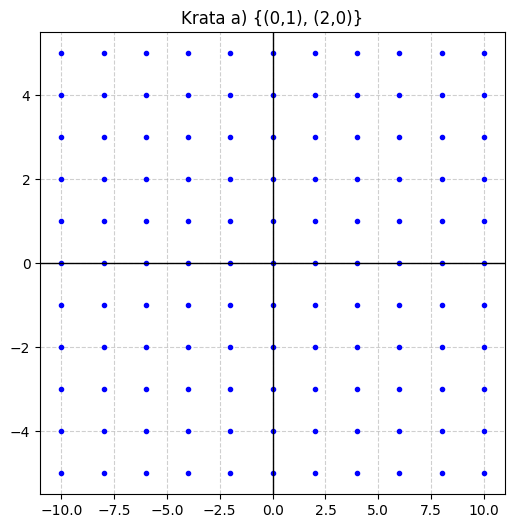

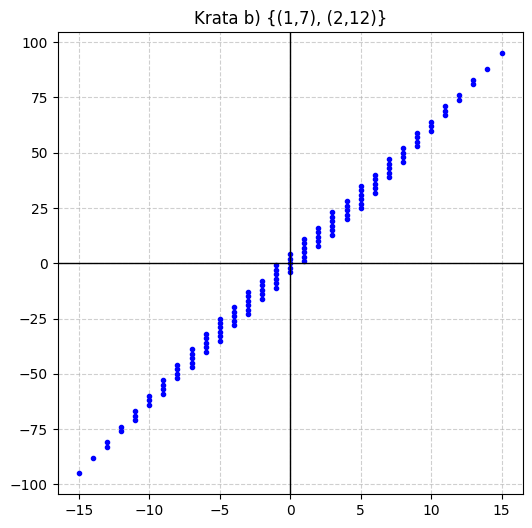

In [46]:
def plot_lattice(v1, v2, title):
    plt.figure(figsize=(6,6))
    for n1 in range(-5, 6):
        for n2 in range(-5, 6):
            x = n1 * v1[0] + n2 * v2[0]
            y = n1 * v1[1] + n2 * v2[1]
            plt.plot(x, y, 'bo', markersize=3)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(title)
    plt.axhline(0, color='black', lw=1)
    plt.axvline(0, color='black', lw=1)
    plt.show()

# a) v1=(0,1), v2=(2,0)
plot_lattice([0,1], [2,0], "Krata a) {(0,1), (2,0)}")

# b) v1=(1,7), v2=(2,12)
plot_lattice([1,7], [2,12], "Krata b) {(1,7), (2,12)}")